In [15]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

from wmfdata import charting, hive

In [16]:
# UPDATE FOR NEW MONTH!
# Start included, end excluded.
# Have to set the end back a couple of months to ensure we only get uncensored data.
# To-do: We take the metric month and look backwards. But this results in censored data
# for months under 30 days (February).

#START = '2019-05'
#END = '2019-06'
#MWH_SNAPSHOT = '2019-07'

last_month = datetime.date.today().replace(day=1) - datetime.timedelta(days=1)
last_two_month = datetime.date.today().replace(day=1) - datetime.timedelta(days= 35)
last_three_month = datetime.date.today().replace(day=1) - datetime.timedelta(days= 70)


START = last_three_month.strftime("%Y-%m")
END = last_two_month.strftime("%Y-%m")
MWH_SNAPSHOT = last_month.strftime("%Y-%m") # The latest available mediawiki_history snapshot

In [19]:
%matplotlib inline
charting.set_mpl_style()

# Update table

In [21]:
# Create the table if necessary
hive.run(
"""
create table if not exists neilpquinn.new_editors (
    user_name string,
    wiki string,
    user_id bigint,
    cohort string,
    1st_month_edits bigint,
    2nd_month_edits bigint
)
-- This allows us to delete data later on (e.g. in case of duplicate inserts)
TBLPROPERTIES ("transactional"="true")
"""
)

# Select and insert the new data. Be careful not to insert duplicate data. Primary 
# keys were introduced in Hive 2.1.0, so until we're running that there's no built-in 
# way to stop duplicates.
hive.run(
"""
insert into table neilpquinn.new_editors
select 
    1st_month.user_name as user_name,
    1st_month.wiki as wiki,
    1st_month.user_id as user_id,
    1st_month.cohort as cohort,
    1st_month.edits as 1st_month_edits,
    coalesce(2nd_month.edits, 0) as 2nd_month_edits
from (
    select
        event_user_text as user_name,
        wiki_db as wiki,
        event_user_id as user_id,
        substr(event_user_creation_timestamp, 0, 7) as cohort,
        count(*) as edits
    from wmf.mediawiki_history
    where
        snapshot = "{snapshot}" and
        event_entity = "revision" and
        event_type = "create" and
        not event_user_is_created_by_system and
        event_user_creation_timestamp between "{start}" and "{end}" and
        unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") <
            (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (30*24*60*60))
    group by event_user_text, event_user_id, event_user_creation_timestamp, wiki_db
    ) 1st_month
left join (
    select
        event_user_text as user_name,
        wiki_db as wiki,
        event_user_id as user_id,
        substr(event_user_creation_timestamp, 0, 7) as cohort,
        count(*) as edits
    from wmf.mediawiki_history
    where
        snapshot = "{snapshot}" and
        event_entity = "revision" and
        event_type = "create" and
        not event_user_is_created_by_system and
        event_user_creation_timestamp between "{start}" and "{end}" and
        unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") >=
            (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (30*24*60*60)) and
        unix_timestamp(event_timestamp, "yyyy-MM-dd HH:mm:ss.0") <
            (unix_timestamp(event_user_creation_timestamp, "yyyy-MM-dd HH:mm:ss.0") + (60*24*60*60))
        group by event_user_text, event_user_id, event_user_creation_timestamp, wiki_db
    ) 2nd_month
on
    (1st_month.user_name = 2nd_month.user_name and
    1st_month.wiki = 2nd_month.wiki and
    1st_month.cohort = 2nd_month.cohort)
""".format(
    snapshot = MWH_SNAPSHOT,
    start = START,
    end = END
))

# Validate

In [25]:
# Check the monthly number of rows (i.e. new editors) from four wikis to check for duplicated data.
new_editors = hive.run(
"""
select wiki, cohort, count(*) as new_editors
from neilpquinn.new_editors
where wiki in ("arwiki", "enwiki", "jawiki", "zhwiki")
group by wiki, cohort
order by wiki, cohort asc
limit 10000
"""
)

new_editors = (
    new_editors
    .assign(cohort = lambda df: pd.to_datetime(df["cohort"]))
    .set_index("cohort")
    .pivot(columns="wiki")
    .xs("new_editors", axis=1)
)
    
new_editors.tail()

wiki,arwiki,enwiki,jawiki,zhwiki
cohort,,,,
2019-02-01,2232.0,47429.0,3035.0,1671.0
2019-03-01,2387.0,51041.0,3268.0,2155.0
2019-04-01,4592.0,90890.0,6230.0,3830.0
2019-05-01,5026.0,85944.0,6706.0,3798.0
2019-06-01,1962.0,39349.0,3122.0,1823.0


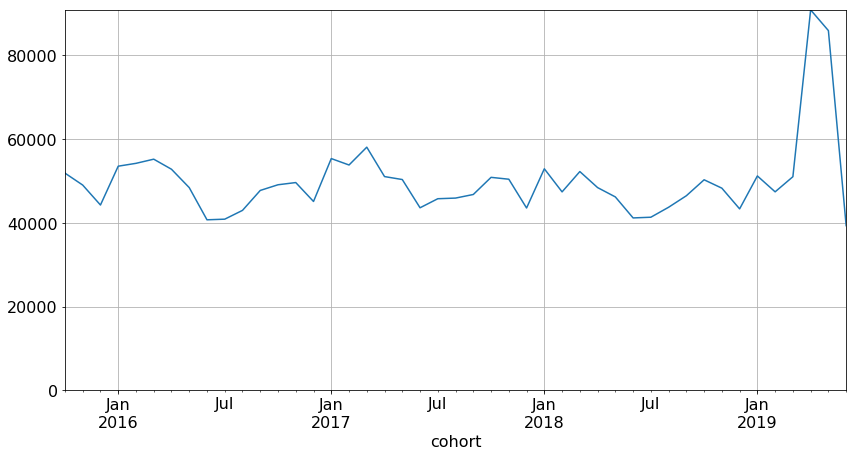

In [26]:
new_editors.loc["2015-10":, "enwiki"].plot()
plt.ylim(0);

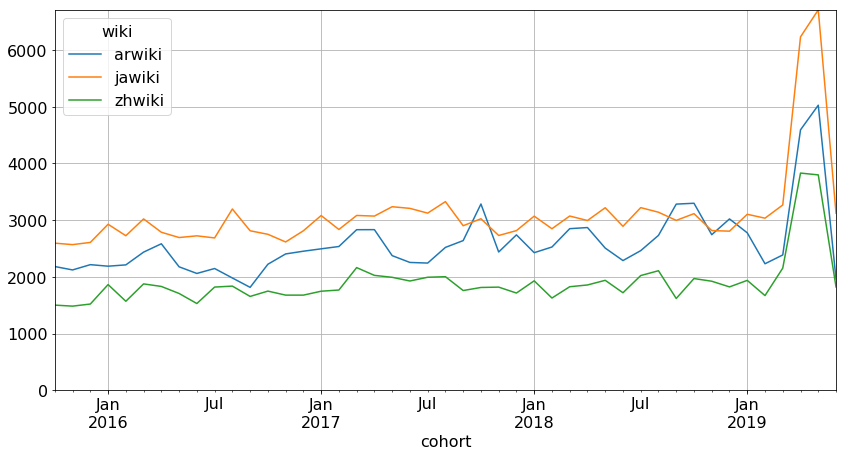

In [27]:
new_editors.loc["2015-10":, ["arwiki", "jawiki", "zhwiki"]].plot()
plt.ylim(0);